what to do?
so when the models have different resolution we could do 2 things:
take highest resolution and for lower res ones take the value of nearest "pixel" for each one (this gives us high res results but lower resolution models will have high errors does not really work for them)
take lowest res and calculate the average of nearby "pixels"(maybe even by their overlap) for each large pixel this will work but only give us low res results

maybe do it individually for each model (so we can use that models res) to get a higher res lowest res estimate. (but that might be difficult and also makes it harder to compare models)

In [1]:
import xarray as xr
import intake
from collections import defaultdict
import matplotlib.pyplot as plt
import xesmf
import numpy as np

wind : v -south-north

u: west-east

In [2]:
path_full = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.nc"
path_1deg = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.1deg.nc"
data = xr.open_dataset(path_full)
data_1deg = xr.open_dataset(path_1deg)

In [3]:
data_wind = data

In [4]:
def lat_lon_sel(data,lat_bnds,lon_bnds,attributes):
    lat_vals = data[attributes[0]][attributes[1]].values
    long_vals = data[attributes[0]][attributes[2]].values

    lat_vals = lat_vals[lat_vals>lat_bnds[0]]
    lat_vals = lat_vals[lat_vals<lat_bnds[1]]

    long_vals = long_vals[long_vals>lon_bnds[0]]
    long_vals = long_vals[long_vals<lon_bnds[1]]
    return lat_vals,long_vals


In [25]:
lat_boundary = [-90,90]#[-32,-14]
long_boundary = [0,360]#[360-78,360-62]
#""" 
"""
lat_boundary = [-34,-12]
long_boundary = [360-80,360-60]
""" #"""
attributes = ["t2m","latitude","longitude"]
#lat_vals,long_vals = lat_lon_sel(data_wind,lat_boundary,long_boundary,attributes)

In [26]:
atts1deg = ["t2m","lat","lon"]
lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary,long_boundary,atts1deg)

In [7]:
#data_wind["v10"].sel({"latitude":lat_vals,"longitude":long_vals}).mean("valid_time").plot()

In [8]:
data_wind.sel({"lat":lat_vals,"lon":long_vals}).mean("valid_time")["u10"].plot()

NameError: name 'lat_vals' is not defined

In [9]:
data_wind["t2m"].sel({"latitude":lat_vals,"longitude":long_vals}).mean("valid_time").plot()

NameError: name 'lat_vals' is not defined

CIMP6 data

In [10]:
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
query = dict(
    variable_id=['tas'],
    table_id='Amon',
    experiment_id=['historical'],
    grid_label='gn',
    member_id='r1i1p1f1'
)

cat_subset = cat.search(require_all_on=["source_id"], **query)
dsets = cat_subset.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    storage_options={'token': 'anon'}
)
list(dsets)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.Amon.gn',
 'CMIP.NCC.NorESM2-LM.historical.Amon.gn',
 'CMIP.UA.MCM-UA-1-0.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn',
 'CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn',
 'CMIP.BCC.BCC-ESM1.historical.Amon.gn',
 'CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.gn',
 'CMIP.AS-RCEC.TaiESM1.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn',
 'CMIP.FIO-QLNM.FIO-ESM-2-0.historical.Amon.gn',
 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn',
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn',
 'CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-2-H.historical.Amon.gn',
 'CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn',
 'CMIP.CAS.FGOALS-g3.historical.Amon.gn',
 'CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn',
 'CMIP.CCCm

In [27]:
dsiter = iter(dsets)

n = 2
current_model = next(dsiter)
#current_model = next(dsiter)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")

atts_cmip = ["tas","lat","lon"]
lat_vals_cmip,lon_vals_cmip = lat_lon_sel(curr_ds,lat_boundary,long_boundary,atts_cmip)

In [82]:
current_model = next(dsiter)
#current_model = next(dsiter)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")

In [83]:
start_date = "1980-01-01"
end_date   = "2005-12-31"
Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
Cmip_data_red = curr_ds["tas"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1])}).sel({"time":slice(start_date,end_date)})

Era5_1deg_red_mean = Era5_1deg_red.mean("time")
Cmip_data_red_mean = Cmip_data_red.mean("time")

regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='bilinear', periodic=True)
regrid_cmip_to_era5_mean = xesmf.Regridder(Cmip_data_red_mean, Era5_1deg_red_mean, method='bilinear', periodic=True)

regrid_era5_to_cmip =  xesmf.Regridder(Era5_1deg_red , Cmip_data_red, method='bilinear', periodic=True)
#regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='conservative', periodic=False)


In [86]:
start_date = "1940-01-01"
end_date   = "2026-12-31"
#Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})
tas = regrid_cmip_to_era5(Cmip_data_red)
E5_regrid = regrid_era5_to_cmip(Era5_1deg_red)
tas_mean = regrid_cmip_to_era5(Cmip_data_red_mean)

In [87]:
b = Era5_1deg_red.resample(time="1ME").nearest()
a = tas.resample(time="1ME").nearest()
a["time"] = a.time.astype("datetime64[ns]")

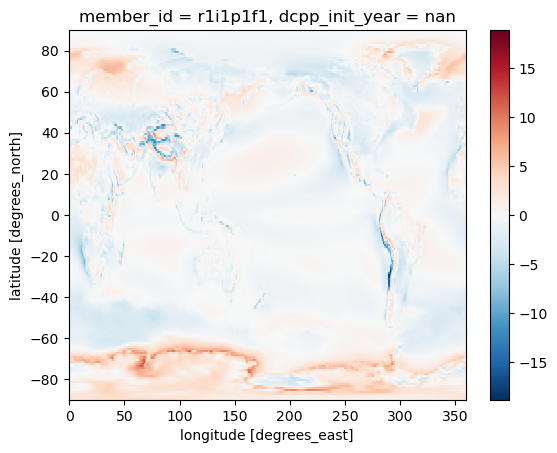

In [88]:
(Era5_1deg_red_mean-tas_mean).plot()

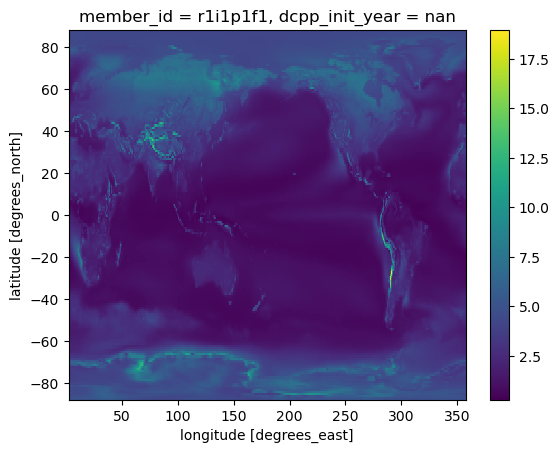

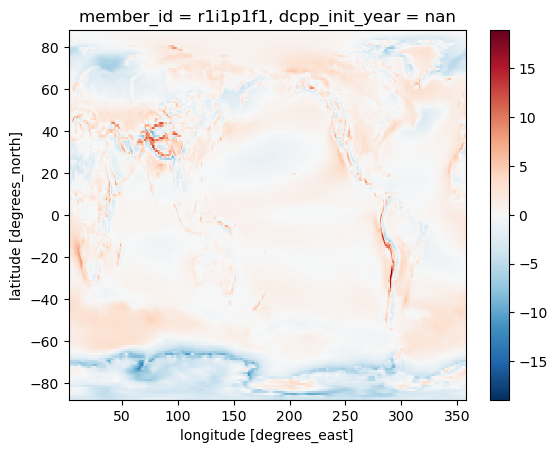

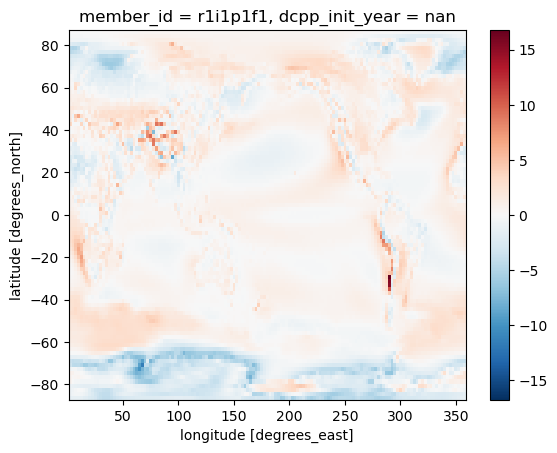

In [91]:
cutoff = 2.1
lat_boundary_adj = [lat_boundary[0]+cutoff,lat_boundary[1]-cutoff]#[-32,-14]
long_boundary_adj =  [long_boundary[0]+cutoff,long_boundary[1]-cutoff]#[360-78,360-62]
atts1deg = ["t2m","lat","lon"]

#lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

a = a.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
b = b.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
(abs(a-b)).mean("time").plot()
plt.figure()
((a-b)).mean("time").plot()



#CMIP scale:
plt.figure()
(Cmip_data_red.mean("time")-E5_regrid.mean("time")).sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])}).plot()

/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning

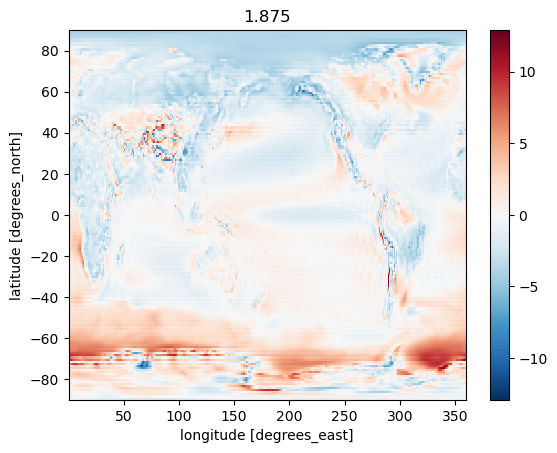

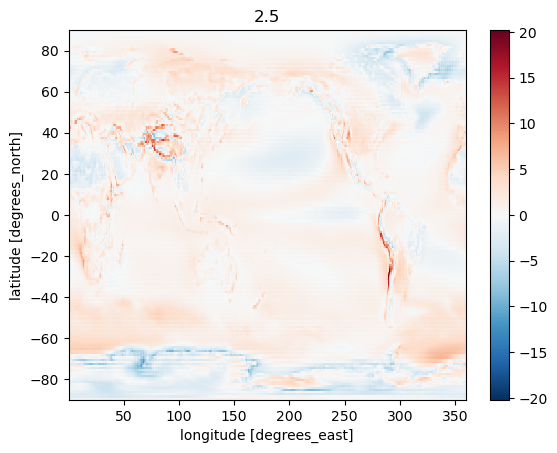

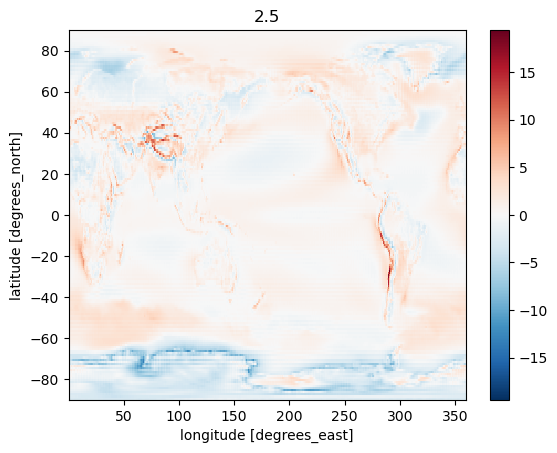

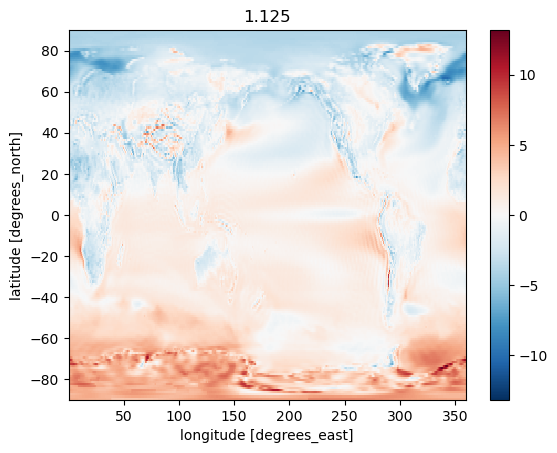

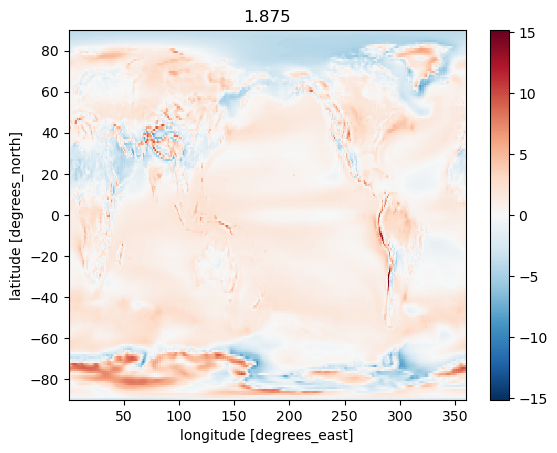

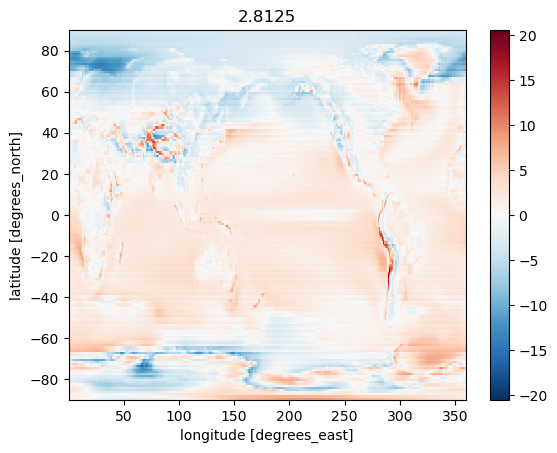

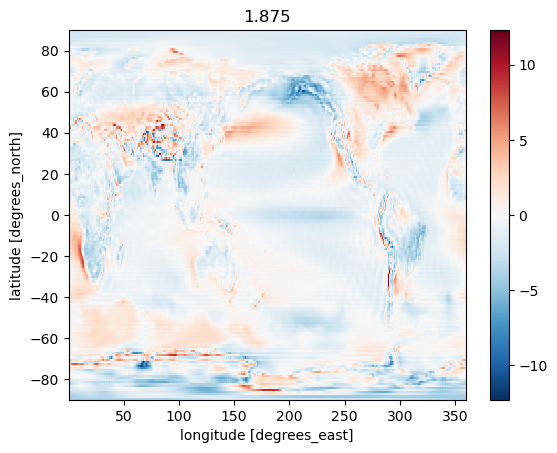

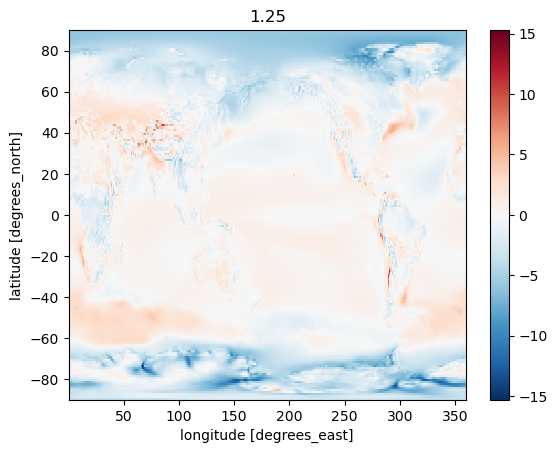

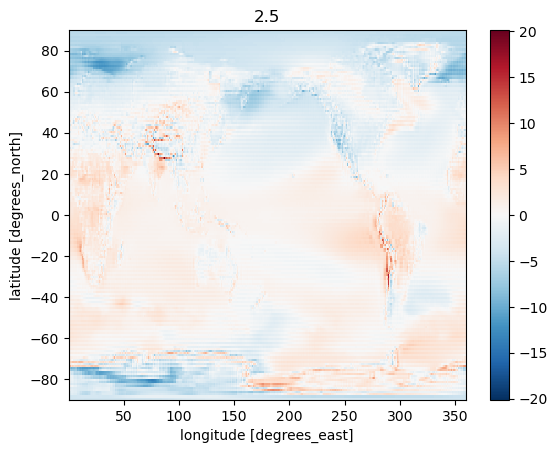

In [92]:

lat_boundary = [-93,93]#[-40,-10]#[-32,-14]
long_boundary =[-3,363]#[360-85,360-55] #[360-78,360-62]

dsiter = iter(dsets)
n = 10
start_date = "1980-01-01"
end_date   = "2005-12-31"
Era5_1deg_red = data_1deg["t2m"].sel({"lat":lat_vals_1deg,"lon":long_vals_1deg}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
b = Era5_1deg_red.resample(time="1ME").nearest()
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    curr_ds = curr_ds.sortby("time")

    
    #datasets use different variable names for their spacial data we want to average over
    if "lat" in dsets[current_model].coords:
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['lat', 'lon']).resample(time="YE").mean().values.ravel()
        

        Cmip_data_red = curr_ds["tas"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1]),"time":slice(start_date,end_date)})

        regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='conservative_normed', periodic=True)
        tas = regrid_cmip_to_era5(Cmip_data_red)
        E5_1deg_month = Era5_1deg_red.resample(time="1ME").nearest()
        cmip5_month = tas.resample(time="1ME").nearest()
        cmip5_month["time"] = cmip5_month.time.astype("datetime64[ns]")

        cutoff = Cmip_data_red.lon.values[1]-Cmip_data_red.lon.values[0]
        lat_boundary_adj = [lat_boundary[0],lat_boundary[1]]#-cutoff]#[-32,-14]
        long_boundary_adj =  [long_boundary[0],long_boundary[1]]#-cutoff]#[360-78,360-62]
        atts1deg = ["t2m","lat","lon"]

        #lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

        cmip5_month = cmip5_month.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
        E5_1deg_month = E5_1deg_month.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
        plt.figure()
        (cmip5_month-E5_1deg_month).mean("time").plot()
        plt.title(str(cutoff))

    elif "i" in dsets[current_model].coords:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean("i").resample(time="YE").mean().values.ravel()
    else:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['latitude', 'longitude']).resample(time="YE").mean().values.ravel()


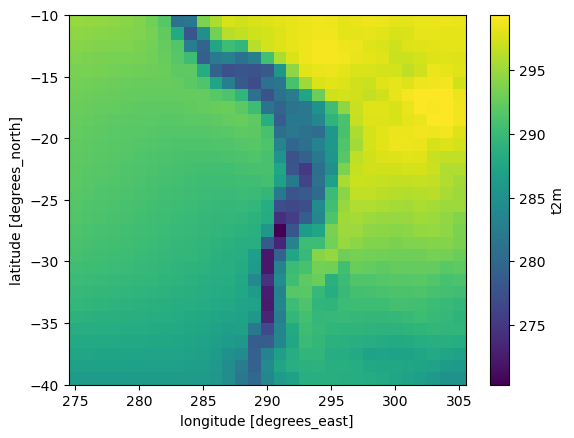

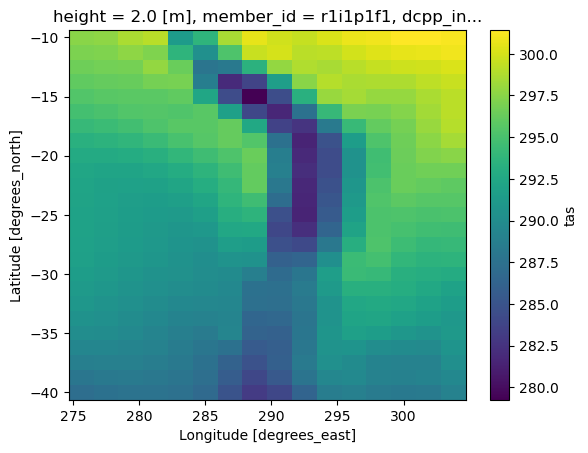

In [31]:

lat_boundary = [-40,-10]#[-32,-14]
long_boundary =[360-85,360-55] #[360-78,360-62]
"""
lat_boundary = [-90,90]#[-32,-14]
long_boundary =[0,360]
"""
Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
dsiter = iter(dsets)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")
Cmip_data_red = curr_ds["tas"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1]),"time":slice(start_date,end_date)})
b = Era5_1deg_red
a = Cmip_data_red
b.mean("time").plot()
plt.figure()
a.mean("time").plot()

In [ ]:
cat_subset.to_datatree()

In [44]:
tree_gm = cat_subset.to_datatree().map_over_subtree(global_mean)

ImportError: .to_datatree() requires the xarray-datatree package to be installed. To proceed please install xarray-datatree using:  `python -m pip install xarray-datatree` or `conda install -c conda-forge xarray-datatree`.

In [39]:
def global_mean(ds):
    try:
        _weights = np.cos(np.deg2rad(ds["lat"]))
        _weights.name = "weights"
        return ds.weighted(_weights).mean(["lat","lon"]).compute().squeeze()
    except:
        print("Global mean as implemented for lat-lon grid does not work:", ds.attrs["institution_id"], ds.attrs["source_id"])

In [ ]:
b = Era5_1deg_red.resample(time="1ME").nearest()
a = tas.resample(time="1ME").nearest()

In [157]:
start_date = "1940-01-01"
end_date   = "2026-12-31"
Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})

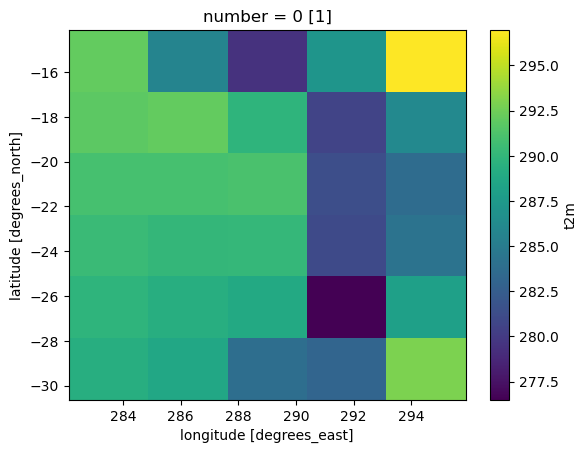

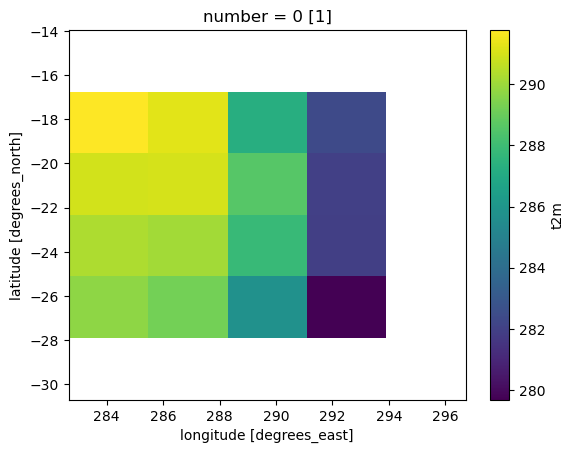

In [106]:
factor=11
Era5_coarse = Era5.coarsen(latitude=factor,longitude=factor,boundary="trim").mean()
Era5_int = Era5_coarse.interp(latitude=d_lat_vals,longitude=d_long_vals,method="linear")
Era5_coarse.plot()
plt.figure()
Era5_int.plot()

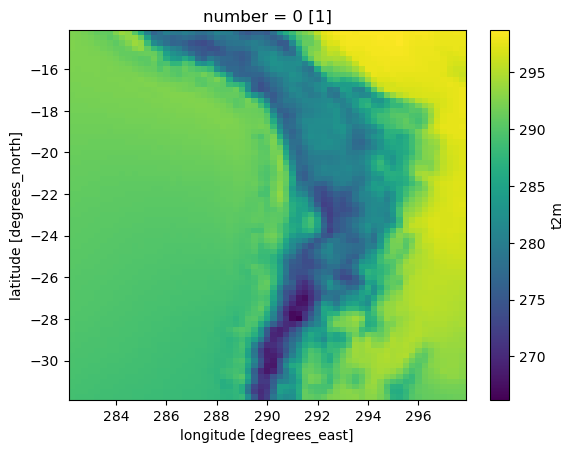

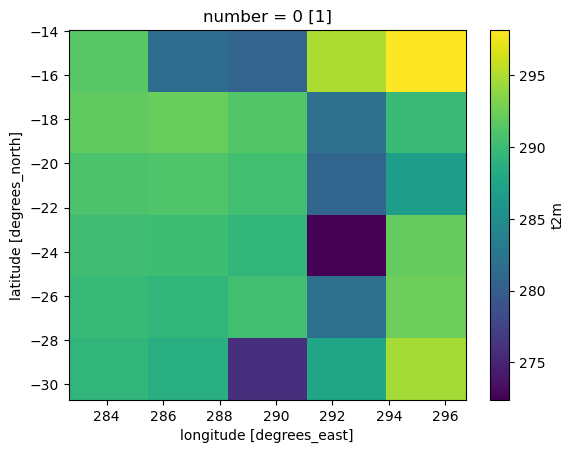

In [69]:
#plt.subplots(1,2)
Era5.plot()
plt.figure()
Era5.interp(latitude=d_lat_vals,longitude=d_long_vals,method="linear").plot()


In [57]:
dsiter = iter(dsets)

n = 36
lattice = []
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    try:
        d_lat_vals = curr_ds["tas"]["lat"].values
        lattice.append((d_lat_vals[1]-d_lat_vals[0]))
    except:
        pass

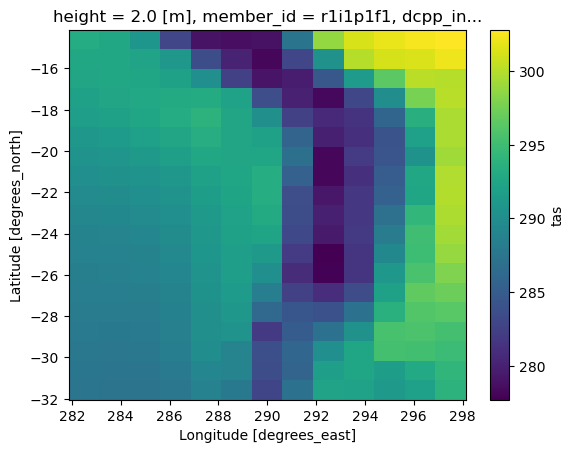

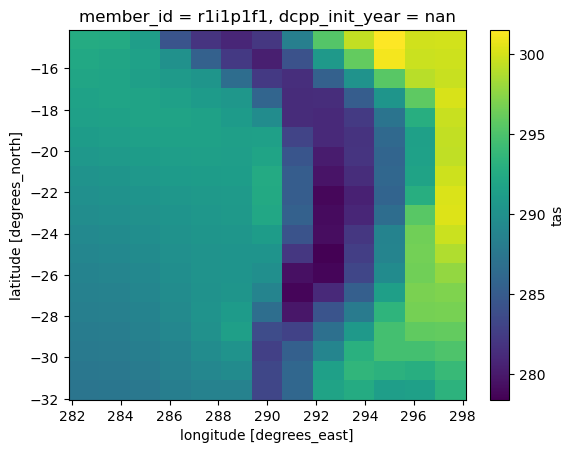

In [ ]:
lat_boundary = [-32,-14]
long_boundary = [360-78,360-62]




dsiter = iter(dsets)

n = 2
times_mean = np.arange(1850,2024,1)         #timesstamps for model mean
model_mean = np.zeros(times_mean.size)      #variable for the mean of the model
model_mean_diff = np.zeros(times_mean.size) #variable for mean anomaly
meancount = np.zeros(times_mean.size)       #count of how many models contribute to the mean(at borders only like 2 models contribute so we cannot divide by n)
maxsize = 0
model_temps = []
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    curr_ds = curr_ds.sortby("time")

    #datasets use different variable names for their spacial data we want to average over
    if "lat" in dsets[current_model].coords:
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['lat', 'lon']).resample(time="YE").mean().values.ravel()
        
        d_lat_vals = curr_ds["tas"]["lat"].values
        d_long_vals = curr_ds["tas"]["lon"].values
        d_lat_vals = d_lat_vals[d_lat_vals>lat_boundary[0]]
        d_lat_vals = d_lat_vals[d_lat_vals<lat_boundary[1]]

        d_long_vals = d_long_vals[d_long_vals>long_boundary[0]]
        d_long_vals = d_long_vals[d_long_vals<long_boundary[1]]
        plt.figure()
        curr_ds["tas"].sel({"lat":d_lat_vals,"lon":d_long_vals}).mean("time").plot()

    elif "i" in dsets[current_model].coords:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean("i").resample(time="YE").mean().values.ravel()
    else:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['latitude', 'longitude']).resample(time="YE").mean().values.ravel()
    """
    m1850_1900 = CMIP_mean_temps[:50].mean()

    times = curr_ds.resample(time="YE").mean()["time"].values.astype('datetime64[Y]')
    label = str.join("-",current_model.split(".")[1:3])

    #calculate the effect on mean of models
    if CMIP_mean_temps.size>maxsize:
        maxsize=CMIP_mean_temps.size
        mtimes=times
    meancount[:CMIP_mean_temps.size]+=1
    model_mean[:CMIP_mean_temps.size] +=+CMIP_mean_temps
    model_mean_diff[:CMIP_mean_temps.size] +=+CMIP_mean_temps-m1850_1900

    model_temps.append([times,CMIP_mean_temps,m1850_1900,label])

times_mean = times_mean[:maxsize]
model_mean = model_mean[:maxsize]/meancount[:maxsize]
model_mean_diff = model_mean_diff[:maxsize]/meancount[:maxsize]
mmm1850_1900 = model_mean[:50].mean()
"""